<div class="alert alert-block alert-info">
    <b>この章の目的</b>
    <p>画像処理で物体の座標を検出する方法を学習します</p>
</div> 

# セットアップ作業

jupyter notebookで画像処理のアルゴリズムを開発するときには、matplotlibがあると便利です。

以下の命令を実行して、jupyter notebook上でmatplotlibを有効化します。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

ROSもセットアップします。

In [2]:
import rospy

rospy.init_node("banana_detector")

# 認識対象の配置

今回、認識対象とするバナナをHSRの前に出現させましょう。

In [3]:
!rosrun gazebo_ros spawn_model -database ycb_011_banana -sdf -model banana -x -2.1 -y 0.6

SpawnModel script started
[INFO] [1578449068.530934, 0.000000]: Loading model XML from Gazebo Model Database
[INFO] [1578449068.531641, 0.000000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1578449068.558793, 0.000000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1578449068.907213, 14.346000]: Spawn status: SpawnModel: Successfully spawned entity


バナナが頭部カメラの画角に入るように頭を少し下げます。

In [4]:
import moveit_commander

head = moveit_commander.MoveGroupCommander("head")
head.set_joint_value_target("head_tilt_joint", -1.0)
head.go()

True

# センサ情報の取得

今回はセンサ情報として、頭部RGBDカメラから取得できるポイントクラウド情報を利用します。

頭部RGBDカメラのポイントクラウド情報には「/hsrb/head_rgbd_sensor/depth_registered/rectified_points」のトピック名でアクセスできます。

In [5]:
!rostopic info /hsrb/head_rgbd_sensor/depth_registered/rectified_points

Type: sensor_msgs/PointCloud2

Publishers: 
 * /gazebo (http://172.29.0.3:33261/)

Subscribers: 
 * /move_base (http://172.29.0.3:44335/)




ポイントクラウド情報の型は「sensor_msgs/PointCloud2」なので、以下のプログラムで情報が取得できます。

ここでは、ポイントクラウド情報をnumpy形式に変換して変数に格納しています。

In [6]:
from sensor_msgs.msg import PointCloud2
import numpy as np
import ros_numpy

def callback(points):
    global points_data, image_data, header_data
    points_data = ros_numpy.numpify(points)
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    header_data = points.header

rospy.Subscriber("/hsrb/head_rgbd_sensor/depth_registered/rectified_points", PointCloud2, callback)

上記のプログラムは、ポイントクラウド情報をpoints_dataに格納するとともに、ポイントクラウドに含まれる画像情報をimage_dataに格納します。

matplotlibを使うと、以下のように取得した画像を表示できます。

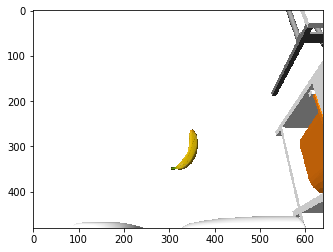

In [7]:
plt.imshow(image_data)

画像データは、480x640x3の3次元配列です。

In [8]:
image_data.shape

(480, 640, 3)

最初の2次元は（y, x）のピクセルに対応します。最後の1次元はRGB形式のピクセル値です。

例えば以下の命令で左上のピクセル値にアクセスできます（RGB値を見ると白色のようです）。

In [9]:
image_data[0][0]

array([255, 255, 255], dtype=uint8)

ポイントクラウド情報には、各ピクセルの3次元座標値が格納されています。

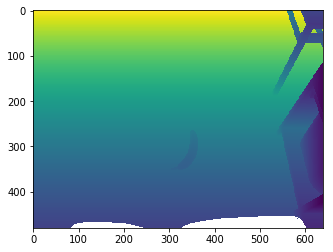

In [10]:
plt.imshow(points_data['z'])

header_dataには、ポイントクラウド情報取得時のタイムスタンプと基準座標が格納されています。

In [11]:
header_data

seq: 888
stamp: 
  secs: 43
  nsecs: 794000000
frame_id: "head_rgbd_sensor_rgb_frame"

# 色空間の変換と色抽出

バナナの色は「黄」なので、色を使ってバナナを検出してみましょう。

「image_data」にはRGB形式で色のデータが格納されています。
RGB形式のデータをそのまま使ってもよいのですが、RGBからHSVに色空間を変換すると照明変化に頑健になることが知られています。

HSVは、色相(Hue)、彩度(Saturation)、明度(Value)によって色を表現します。今回は色相情報のみを利用してバナナの黄色を抽出します。

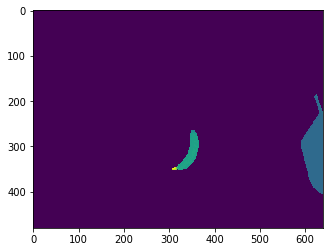

In [12]:
import cv2

hsv_image = cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV_FULL)
h_image = hsv_image[..., 0]
plt.imshow(h_image)

色相画像に対して適当な閾値を設定して、バナナのみが抽出されるようにします。

In [13]:
from ipywidgets import interact

def f(lower = 0, upper = 255):
    yellow_region = (h_image > lower) & (h_image < upper)
    plt.imshow(yellow_region)

interact(f, lower=(0, 255, 5), upper=(0, 255, 5))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2xvd2VyJywgbWF4PTI1NSwgc3RlcD01KSwgSW50U2xpZGVyKHZhbHVlPTI1NSwgZGVzY3JpcHTigKY=


<function __main__.f>

閾値を下限25、上限50ぐらいに設定すると安定して抽出できるようです。

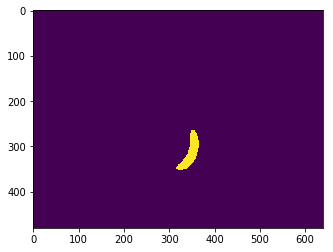

In [14]:
yellow_region = (h_image > 25) & (h_image < 50)
plt.imshow(yellow_region)

バナナと考えられる領域の配列インデックスを取得します。

In [15]:
(y_idx, x_idx) = np.where(yellow_region == True)

ポイントクラウド情報から、バナナと考えられる領域のxyz座標の平均値を計算します。

In [16]:
x = np.average(points_data['x'][y_idx, x_idx])
y = np.average(points_data['y'][y_idx, x_idx])
z = np.average(points_data['z'][y_idx, x_idx])

バナナのxyz座標が以下のように計算できました。

In [17]:
(x, y, z)

(0.050111283, 0.13117738, 1.0020655)

このxyz値は、以下の基準座標上での値です。

In [18]:
header_data.frame_id

'head_rgbd_sensor_rgb_frame'

# 関数化とTF情報のpublish

上記の処理を関数化してTF情報をpublishしてみます。

In [1]:
import rospy
from sensor_msgs.msg import PointCloud2
from geometry_msgs.msg import TransformStamped
import numpy as np
import ros_numpy
import cv2
import tf

rospy.init_node("banana_detector")
br = tf.TransformBroadcaster()

def callback(points):
    points_data = ros_numpy.numpify(points)
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]

    hsv_image = cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV_FULL)
    h_image = hsv_image[..., 0]

    yellow_region = (h_image > 25) & (h_image < 50)

    (y_idx, x_idx) = np.where(yellow_region == True)
    x = np.average(points_data['x'][y_idx, x_idx])
    y = np.average(points_data['y'][y_idx, x_idx])
    z = np.average(points_data['z'][y_idx, x_idx])

    br.sendTransform((x, y, z), tf.transformations.quaternion_from_euler(0, 0, 0),
                    rospy.Time(points.header.stamp.secs, points.header.stamp.nsecs),
                    "banana",
                    points.header.frame_id)

rospy.Subscriber("/hsrb/head_rgbd_sensor/depth_registered/rectified_points", PointCloud2, callback)

上記プログラムを実行すると、新しいポイントクラウド情報が入力されるたびにbananaのTF情報がpublishされます。

rvizを立ち上げて、RobotModelとTFをAddして、bananaのTFが正しくpublishされているか確認しましょう。

In [2]:
!import -window root /tmp/screen.png

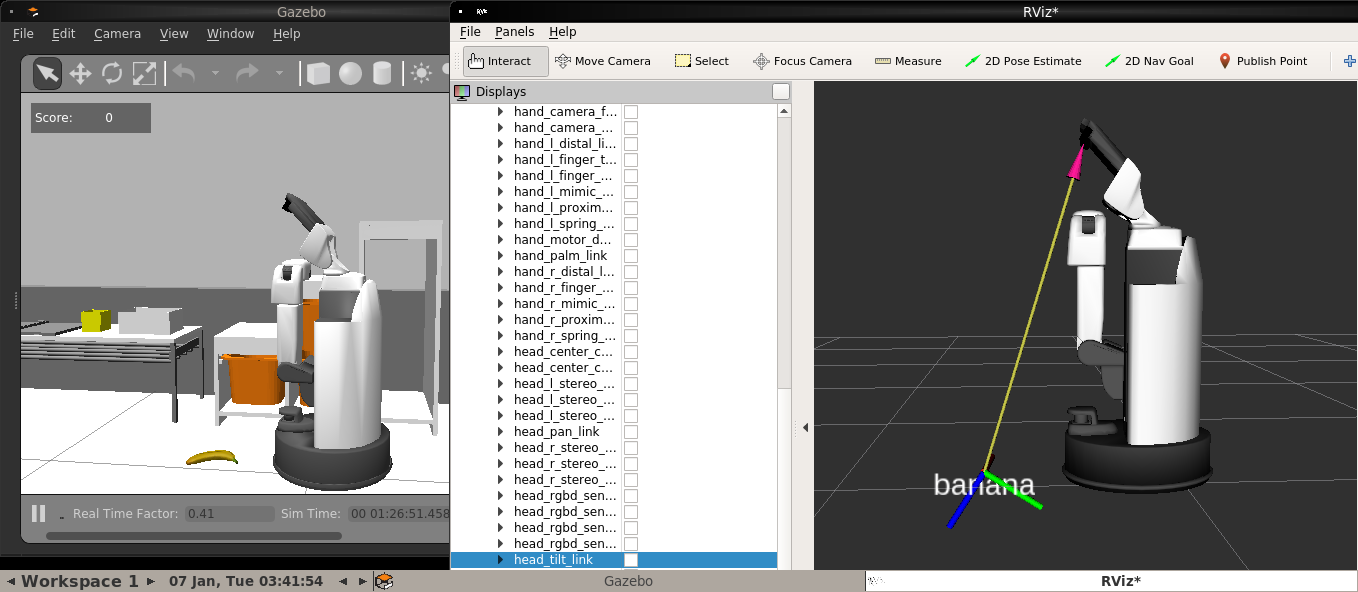

In [3]:
from IPython.display import Image
with open('/tmp/screen.png','rb') as file:
    display(Image(data=file.read()))

TF情報はPythonでもアクセスできます。

例えば、絶対座標（odom）上でのbananaの位置は以下のように取得できます。

In [2]:
listener = tf.TransformListener()
listener.waitForTransform('odom', 'banana', rospy.Time(), rospy.Duration(4.0))
listener.lookupTransform('odom', 'banana', rospy.Time(0))

([0.587748409167213, -0.008933772880286408, 0.04253780635746651],
 [-0.6939073982318528,
  0.6636835085014329,
  -0.19306046911479208,
  0.20185236805028034])

bananaは、絶対座標上で約（x, y）=（0.6, 0.0）の座標に置かれているようです。